In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

C:\Users\saban.kara\Anaconda3\envs\tga\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [3]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

### Plot Utility

In [4]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

## Model 1: Flatten

First up is simply using a `Flatten` layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

In [5]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 1s 3ms/step - loss: 0.5999 - accuracy: 0.6657 - val_loss: 0.3930 - val_accuracy: 0.8300
Epoch 2/10
196/196 [==============================] - 1s 3ms/step - loss: 0.3131 - accuracy: 0.8719 - val_loss: 0.3309 - val_accuracy: 0.8560
Epoch 3/10
196/196 [==============================] - 1s 3ms/step - loss: 0.2048 - accuracy: 0.9270 - val_loss: 0.3519 - val_accuracy: 0.8485
Epoch 4/10
196/196 [==============================] - 1s 3ms/step - loss: 0.1207 - accuracy: 0.9663 - val_loss: 0.3957 - val_accuracy: 0.8393
Epoch 5/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0588 - accuracy: 0.9910 - val_loss: 0.4389 - val_accuracy: 0.8371
Epoch 6/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0264 - accuracy: 0.9980 - val_loss: 0.4831 - val_accuracy: 0.8348
Epoch 7/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0131 - accuracy: 0.9995 - val_loss: 0.5198 - val_accuracy: 0.8342
Epoch 

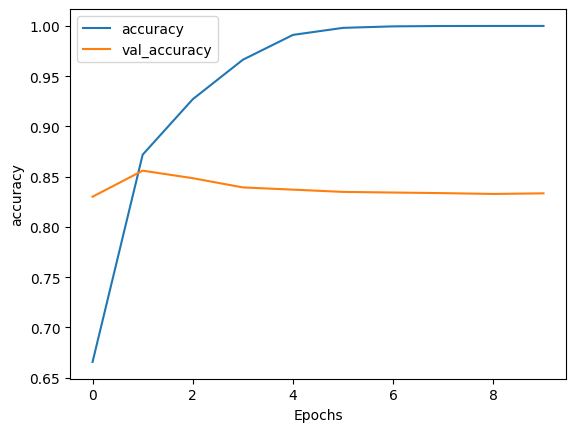

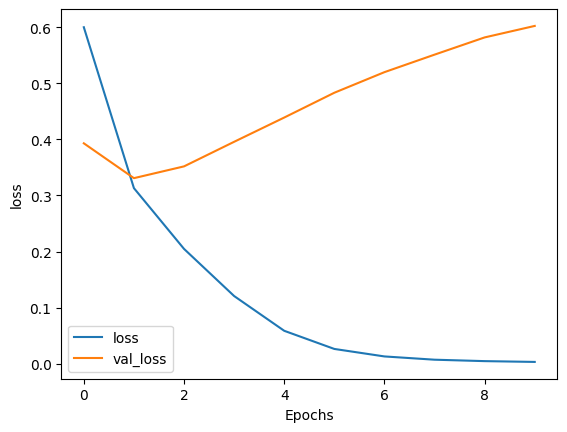

In [6]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded,
                                    training_labels_final,
                                    batch_size=BATCH_SIZE,
                                    epochs=NUM_EPOCHS,
                                    validation_data=(testing_padded, testing_labels_final))

# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

## LSTM

It is slower to train but useful in applications where the order of tokens is important.

In [7]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 11s 45ms/step - loss: 0.5380 - accuracy: 0.7192 - val_loss: 0.3814 - val_accuracy: 0.8314
Epoch 2/10
196/196 [==============================] - 9s 44ms/step - loss: 0.3167 - accuracy: 0.8713 - val_loss: 0.3550 - val_accuracy: 0.8448
Epoch 3/10
196/196 [==============================] - 8s 43ms/step - loss: 0.2464 - accuracy: 0.9071 - val_loss: 0.4110 - val_accuracy: 0.8366
Epoch 4/10
196/196 [==============================] - 8s 41ms/step - loss: 0.2111 - accuracy: 0.9227 - val_loss: 0.3813 - val_accuracy: 0.8348
Epoch 5/10
196/196 [==============================] - 8s 42ms/step - loss: 0.1805 - accuracy: 0.9376 - val_loss: 0.4845 - val_accuracy: 0.8188
Epoch 6/10
196/196 [==============================] - 8s 42ms/step - loss: 0.1572 - accuracy: 0.9476 - val_loss: 0.4715 - val_accuracy: 0.8214
Epoch 7/10
196/196 [==============================] - 8s 43ms/step - loss: 0.1327 - accuracy: 0.9575 - val_loss: 0.5756 - val_accuracy: 0.813

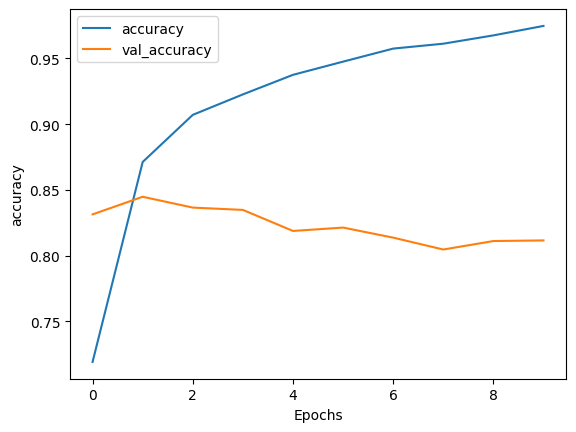

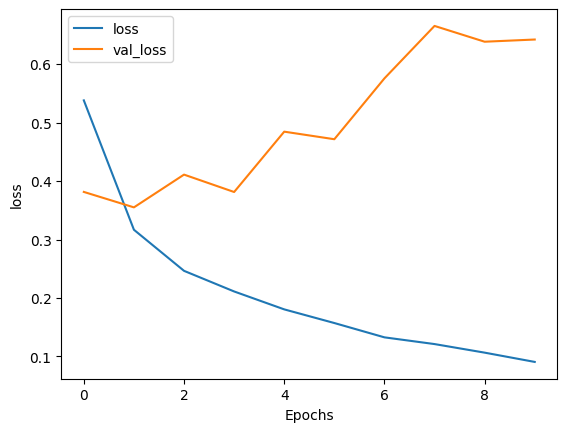

In [8]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, 
                              training_labels_final, 
                              batch_size=BATCH_SIZE, 
                              epochs=NUM_EPOCHS, 
                              validation_data=(testing_padded, testing_labels_final))

# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

## GRU

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) often referred to as a simpler version of LSTM. It can be used in applications where the index is important but you want faster results and may sacrifice some accuracy. In the model summary it is slightly smaller than the LSTM and also runs a few seconds faster.

In [9]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 11s 41ms/step - loss: 0.5854 - accuracy: 0.6609 - val_loss: 0.3920 - val_accuracy: 0.8249
Epoch 2/10
196/196 [==============================] - 7s 37ms/step - loss: 0.3264 - accuracy: 0.8658 - val_loss: 0.3528 - val_accuracy: 0.8479
Epoch 3/10
196/196 [==============================] - 7s 37ms/step - loss: 0.2542 - accuracy: 0.9019 - val_loss: 0.3594 - val_accuracy: 0.8446
Epoch 4/10
196/196 [==============================] - 7s 36ms/step - loss: 0.2057 - accuracy: 0.9261 - val_loss: 0.4001 - val_accuracy: 0.8362
Epoch 5/10
196/196 [==============================] - 7s 36ms/step - loss: 0.1658 - accuracy: 0.9425 - val_loss: 0.4618 - val_accuracy: 0.8277
Epoch 6/10
196/196 [==============================] - 7s 36ms/step - loss: 0.1316 - accuracy: 0.9560 - val_loss: 0.5034 - val_accuracy: 0.8223
Epoch 7/10
196/196 [==============================] - 7s 36ms/step - loss: 0.1140 - accuracy: 0.9628 - val_loss: 0.5669 - val_accuracy: 0.819

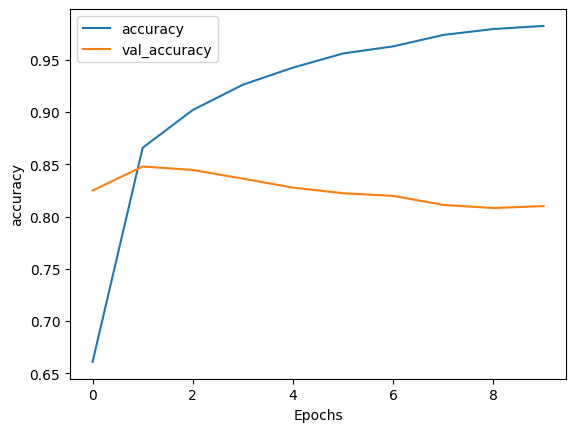

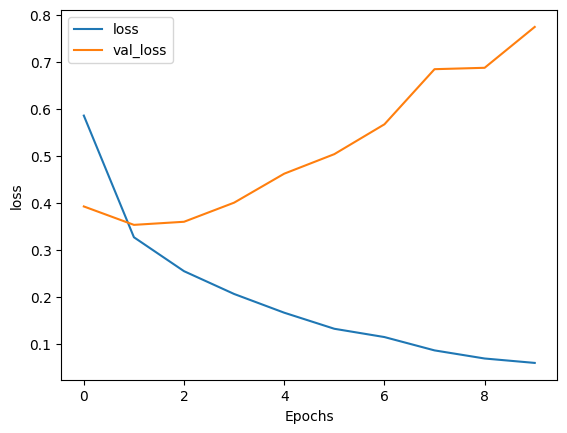

In [10]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, 
                            training_labels_final, 
                            batch_size=BATCH_SIZE, 
                            epochs=NUM_EPOCHS, 
                            validation_data=(testing_padded, testing_labels_final))

# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

## Convolution

[GlobalAveragePooling1d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer. Like the model with the "Flatten" feature, this trains much faster than models using RNN layers such as "LSTM" and "GRU".

In [11]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

Epoch 1/10
196/196 [==============================] - 4s 16ms/step - loss: 0.5723 - accuracy: 0.6700 - val_loss: 0.3661 - val_accuracy: 0.8390
Epoch 2/10
196/196 [==============================] - 3s 17ms/step - loss: 0.3138 - accuracy: 0.8687 - val_loss: 0.3449 - val_accuracy: 0.8498
Epoch 3/10
196/196 [==============================] - 3s 15ms/step - loss: 0.2498 - accuracy: 0.9000 - val_loss: 0.3603 - val_accuracy: 0.8463
Epoch 4/10
196/196 [==============================] - 3s 16ms/step - loss: 0.2129 - accuracy: 0.9192 - val_loss: 0.3896 - val_accuracy: 0.8409
Epoch 5/10
196/196 [==============================] - 3s 16ms/step - loss: 0.1886 - accuracy: 0.9302 - val_loss: 0.4359 - val_accuracy: 0.8295
Epoch 6/10
196/196 [==============================] - 3s 15ms/step - loss: 0.1636 - accuracy: 0.9419 - val_loss: 0.4566 - val_accuracy: 0.8318
Epoch 7/10
196/196 [==============================] - 3s 15ms/step - loss: 0.1444 - accuracy: 0.9504 - val_loss: 0.4975 - val_accuracy: 0.8248

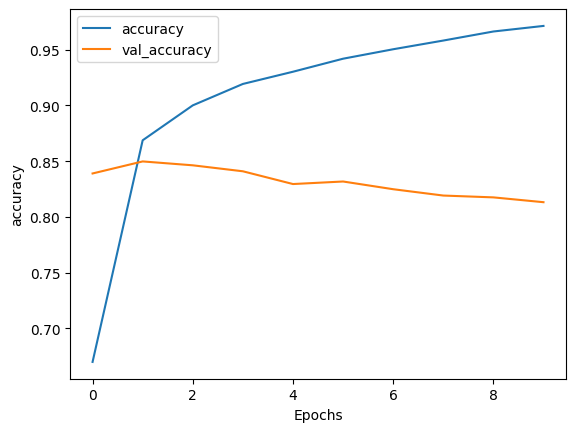

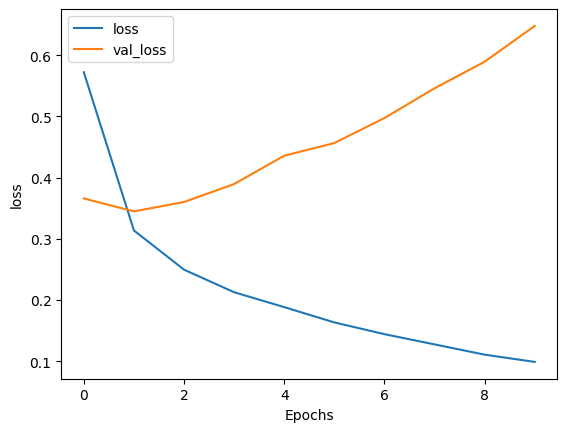

In [12]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, 
                              training_labels_final, 
                              batch_size=BATCH_SIZE, 
                              epochs=NUM_EPOCHS, 
                              validation_data=(testing_padded, testing_labels_final))

# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')